<a href="https://colab.research.google.com/github/galvaowesley/DataScience_Learning/blob/master/minicurso_dataScience/Semana_9/%C3%8Dndice_Socioecon%C3%B4micos_Brasil_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análise de índices socioecônomicos - Brasil
===

Wesley Galvão

In [ ]:
# Instalação de pacotes
install.packages(c('devtools', 'ggplot2','tidyr', 'scales', 'ggpubr', 
                   'gridExtra', 'dynlm', 'plotly', 'readxl', 'reshape2'))
# Instalação dos pacotes que contêm os conjuntos de dados
install.packages('sidrar')

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘corrplot’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘farver’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘zoo’, ‘car’, ‘lmtest’, ‘hexbin’, ‘data.table’, ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’, ‘rjson’




In [ ]:
# Carregamento de pacotes e base de dados
library(ggplot2)
library(reshape2) # Melt correlation matrix
library(tidyr)
library(gridExtra)
library(dynlm)
library(plotly)
library(readxl)
library(sidrar)
library(ggpubr)

# Configuração do ambiente
options(warn=-1)
options(repr.plot.width = 14, repr.plot.height = 8)

theme = 
  theme_minimal() +
  theme(
    plot.title    = element_text(size=18, face="bold", color="gray30"),
    plot.subtitle = element_text(size=15, color="gray30"),
    axis.title    = element_text(size=15, color="gray30"),
    axis.text     = element_text(size = 13),
    plot.caption  = element_text(size=15, color = "gray60"),
    legend.text   = element_text(size=15, color="gray30"),
    legend.title  = element_text(size=15, color="gray30"),
    strip.text.x  = element_text(size=13, color="gray30")
  )


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [ ]:
# http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization
# Get lower triangle of the correlation matrix
  get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)
  }
  # Get upper triangle of the correlation matrix
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

SIDRAR IBGE
===

O pacote SIDRAR é disponibilizado pela plataforma [Sistema IBGE de Recuperação Automática](https://sidra.ibge.gov.br/home/ipca/brasil). Contém importantes índices socioeconômicos, como IPCA15 e PIB.




# Produto Interno Bruto

## Conhecendo os dados

### Dicionário

- `agropecuaria` : Agropecuária - total
- `desp_gov`  :  Despesa de consumo da administração pública 
- `desp_fam` : Despesa de consumo das famílias 
- `exportacao` : Exportação de bens e serviços
- `fbcf` : Formação bruta de capital fixo
- `importacao` : Importação de bens e serviços (-)
- `industria` : Indústria - total 
- `pib` : PIB a preços de mercado 
- `servicos`  : Serviços - total


In [ ]:
# Importação de dados sem ajustes sazonais
tabela_pib = get_sidra(api='/t/1620/n1/all/v/all/p/all/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v583%202') %>%
  mutate(date = as.yearqtr(`Trimestre (Código)`, format='%Y%q')) %>%
  select(date, `Setores e subsetores`, Valor) %>%
  spread(`Setores e subsetores`, Valor) %>%
  rename(`agropecuaria`=`Agropecuária - total`,
         `desp_gov` = `Despesa de consumo da administração pública`, 
         `desp_fam` = `Despesa de consumo das famílias` ,
         `exportacao` = `Exportação de bens e serviços`,
         `fbcf` = `Formação bruta de capital fixo`,
         `importacao` = `Importação de bens e serviços (-)`,
         `industria` = `Indústria - total`, 
         `pib` = `PIB a preços de mercado`, 
         `servicos` = `Serviços - total`) %>%
  as_tibble()

tail(tabela_pib)

All others arguments are desconsidered when 'api' is informed



date,agropecuaria,desp_gov,desp_fam,exportacao,fbcf,importacao,industria,pib,servicos
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018 Q4,154.81,150.74,186.04,327.60,145.95,256.81,133.42,168.36,178.42
2019 Q1,278.87,142.87,177.04,290.94,138.06,236.58,125.74,165.81,172.14
2019 Q2,258.96,148.16,177.91,314.47,145.29,243.09,131.08,168.70,175.28
2019 Q3,222.42,147.40,183.30,315.65,157.39,279.42,140.31,172.89,179.01
2019 Q4,155.49,151.24,189.87,310.98,145.43,256.25,135.37,171.17,181.34
2020 Q1,284.18,142.87,175.75,284.46,143.96,248.71,125.59,165.39,171.36


In [ ]:
# Importação de dados com ajustes sazonais
tabela_pib_sa = get_sidra(api='/t/1621/n1/all/v/all/p/all/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v584%202') %>%
  mutate(date = as.yearqtr(`Trimestre (Código)`, format='%Y%q')) %>%
  select(date, `Setores e subsetores`, Valor) %>%
  spread(`Setores e subsetores`, Valor) %>%
  rename(`agropecuaria_sa`=`Agropecuária - total`,
         `desp_gov_sa` = `Despesa de consumo da administração pública`, 
         `desp_fam_sa` = `Despesa de consumo das famílias` ,
         `exportacao_sa` = `Exportação de bens e serviços`,
         `fbcf_sa` = `Formação bruta de capital fixo`,
         `importacao_sa` = `Importação de bens e serviços (-)`,
         `industria_sa` = `Indústria - total`, 
         `pib_sa` = `PIB a preços de mercado`, 
         `servicos_sa` = `Serviços - total`) %>%
  as_tibble()

tail(tabela_pib_sa, 3)

All others arguments are desconsidered when 'api' is informed



date,agropecuaria_sa,desp_gov_sa,desp_fam_sa,exportacao_sa,fbcf_sa,importacao_sa,industria_sa,pib_sa,servicos_sa
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019 Q3,231.16,146.88,182.41,300.07,149.61,259.44,133.79,170.08,177.02
2019 Q4,230.21,147.49,183.17,306.87,145.59,250.83,133.82,170.70,178.22
2020 Q1,231.52,147.84,179.54,304.07,150.10,257.87,131.97,168.07,175.30


### Análise das componentes

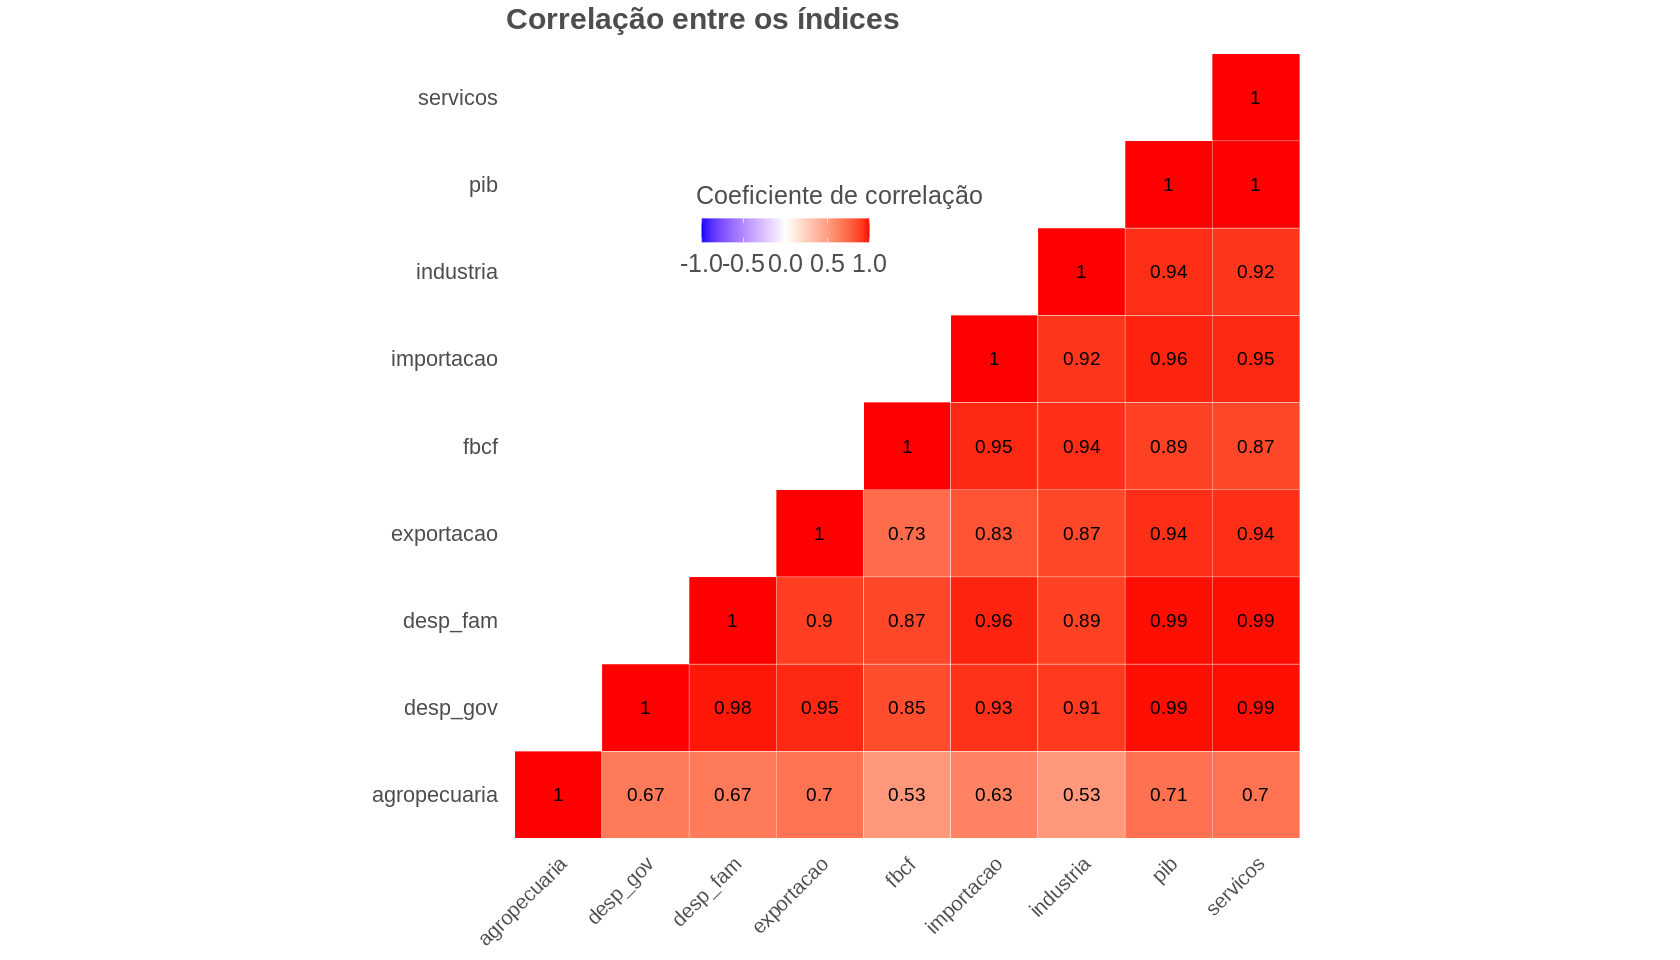

In [ ]:
# Matrix de correlação
cormat <- round(cor(tabela_pib[, c(2:10)]),2)
upper_tri <- get_upper_tri(cormat)
melted_cormat <- melt(upper_tri, na.rm = TRUE)

# Heatmap
 ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
     geom_tile(color = "white") +
     labs(title = "Correlação entre os índices") +
     scale_fill_gradient2(low = "blue", 
                          high = "red", 
                          mid = "white", 
                          midpoint = 0, 
                          limit = c(-1,1), 
                          space = "Lab", 
                          name="Coeficiente de correlação") +
     coord_fixed() + theme + 
     geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
     theme(
      axis.text.x = element_text(angle = 45, vjust = 1,size = 12, hjust = 1),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                    title.position = "top", title.hjust = 0.5))

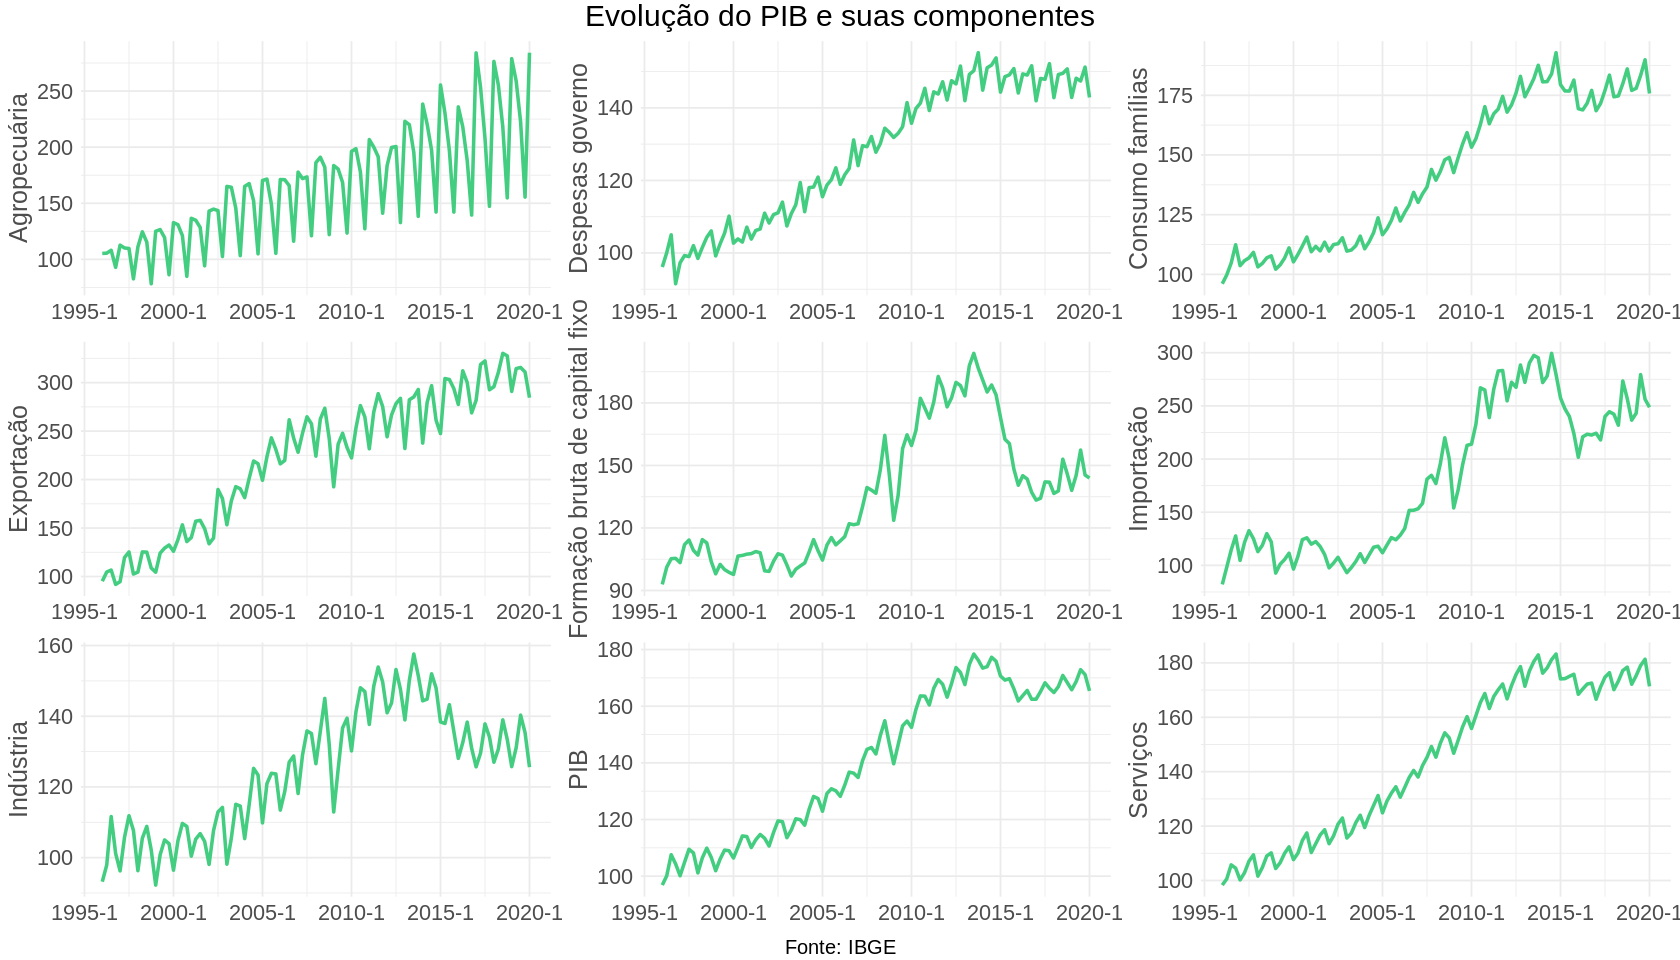

In [ ]:
# plots das componentes do PIB a partir do conjunto de dados sem ajustes sazonais 

p1 = ggplot(tabela_pib, aes(x = date, y = agropecuaria)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Agropecuária") + 
        theme  + theme(axis.title.x = element_blank())

p2 = ggplot(tabela_pib, aes(x = date, y = desp_gov)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Despesas governo") +
        theme  + theme(axis.title.x = element_blank())

p3 = ggplot(tabela_pib, aes(x = date, y = desp_fam)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Consumo famílias") +
        theme  + theme(axis.title.x = element_blank())

p4 = ggplot(tabela_pib, aes(x = date, y = exportacao)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Exportação") +
        theme  + theme(axis.title.x = element_blank())

p5 = ggplot(tabela_pib, aes(x = date, y = fbcf)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Formação bruta de capital fixo") +
        theme  + theme(axis.title.x = element_blank())

p6 = ggplot(tabela_pib, aes(x = date, y = importacao)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Importação") +
        theme  + theme(axis.title.x = element_blank())

p7 = ggplot(tabela_pib, aes(x = date, y = industria)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Indústria") +
        theme  + theme(axis.title.x = element_blank())

p8 = ggplot(tabela_pib, aes(x = date, y = pib)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "PIB") +
        theme  + theme(axis.title.x = element_blank())

p9 = ggplot(tabela_pib, aes(x = date, y = servicos)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Serviços") +
        theme  + theme(axis.title.x = element_blank())

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, nrow = 3, 
             top = text_grob('Evolução do PIB e suas componentes', size = 18), 
             bottom = 'Fonte: IBGE')


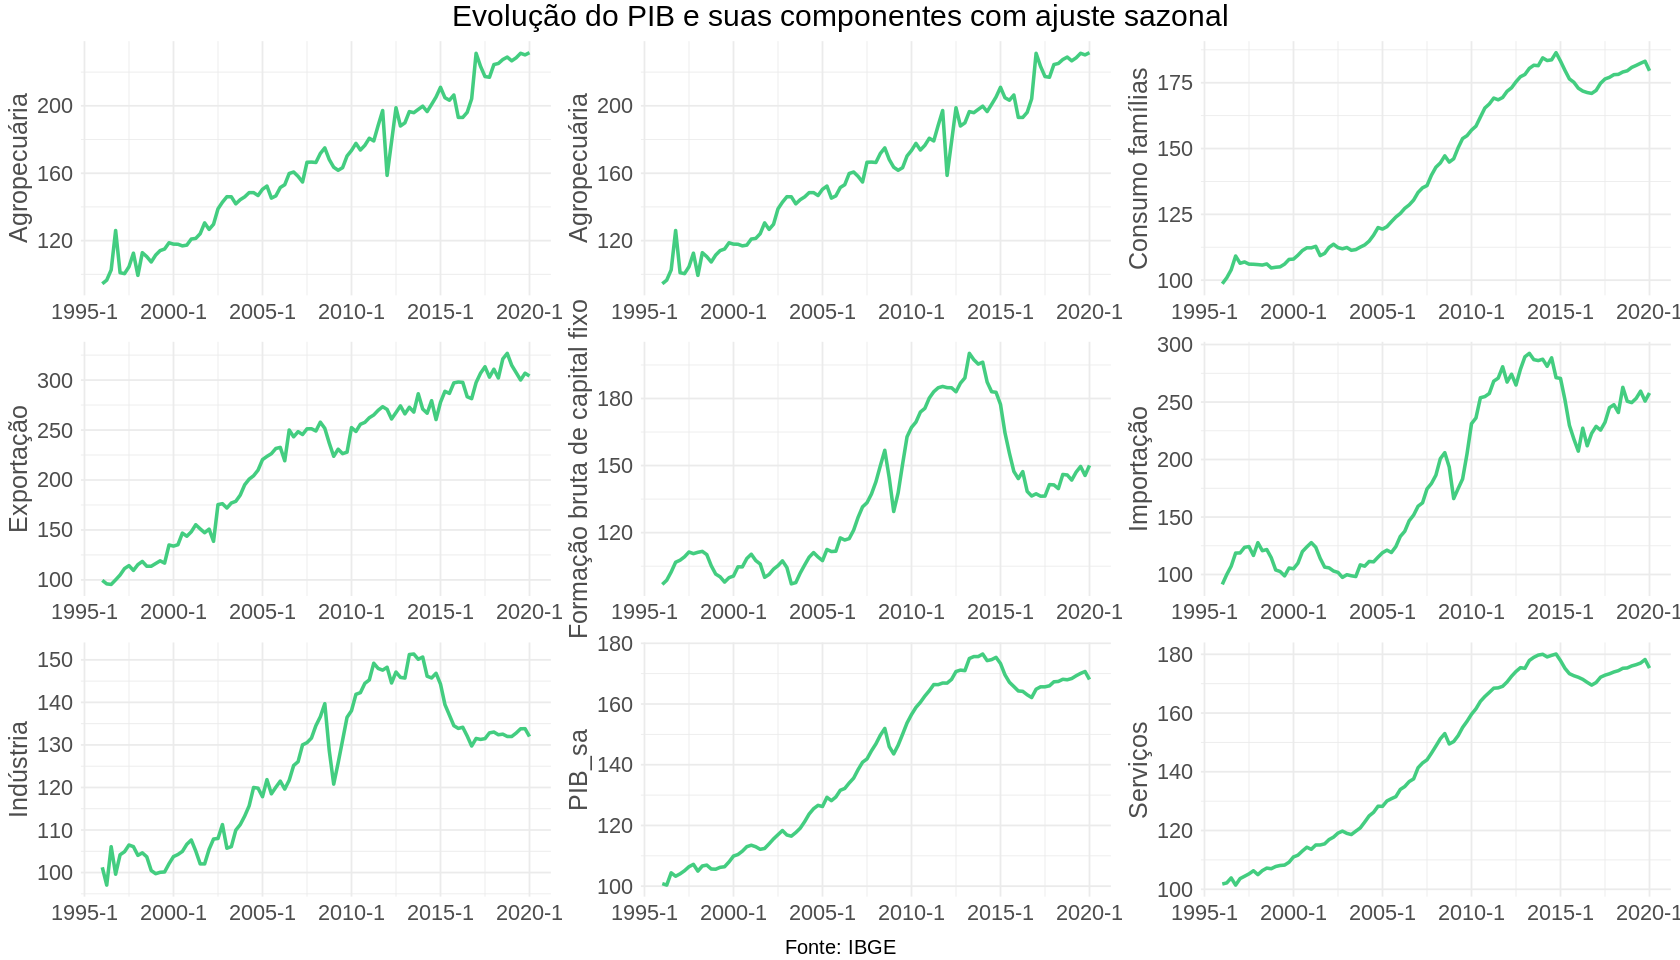

In [ ]:
# plots das componentes do PIB a partir do conjunto de dados com ajustes sazonais 

p10 = ggplot(tabela_pib_sa, aes(x = date, y = agropecuaria_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Agropecuária") + 
        theme  + theme(axis.title.x = element_blank())

p11 = ggplot(tabela_pib_sa, aes(x = date, y = desp_gov_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Despesas governo") +
        theme  + theme(axis.title.x = element_blank())

p12 = ggplot(tabela_pib_sa, aes(x = date, y = desp_fam_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Consumo famílias") +
        theme  + theme(axis.title.x = element_blank())

p13 = ggplot(tabela_pib_sa, aes(x = date, y = exportacao_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Exportação") +
        theme  + theme(axis.title.x = element_blank())

p14 = ggplot(tabela_pib_sa, aes(x = date, y = fbcf_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Formação bruta de capital fixo") +
        theme  + theme(axis.title.x = element_blank())

p15 = ggplot(tabela_pib_sa, aes(x = date, y = importacao_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Importação") +
        theme  + theme(axis.title.x = element_blank())

p16 = ggplot(tabela_pib_sa, aes(x = date, y = industria_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Indústria") +
        theme  + theme(axis.title.x = element_blank())

p17 = ggplot(tabela_pib_sa, aes(x = date, y = pib_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "PIB_sa") +
        theme  + theme(axis.title.x = element_blank())

p18 = ggplot(tabela_pib_sa, aes(x = date, y = servicos_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Serviços") +
        theme  + theme(axis.title.x = element_blank())

grid.arrange(p10, p10, p12, p13, p14, p15, p16, p17, p18, nrow = 3, 
             top = text_grob('Evolução do PIB e suas componentes com ajuste sazonal', size = 18) ,
             bottom = 'Fonte: IBGE')

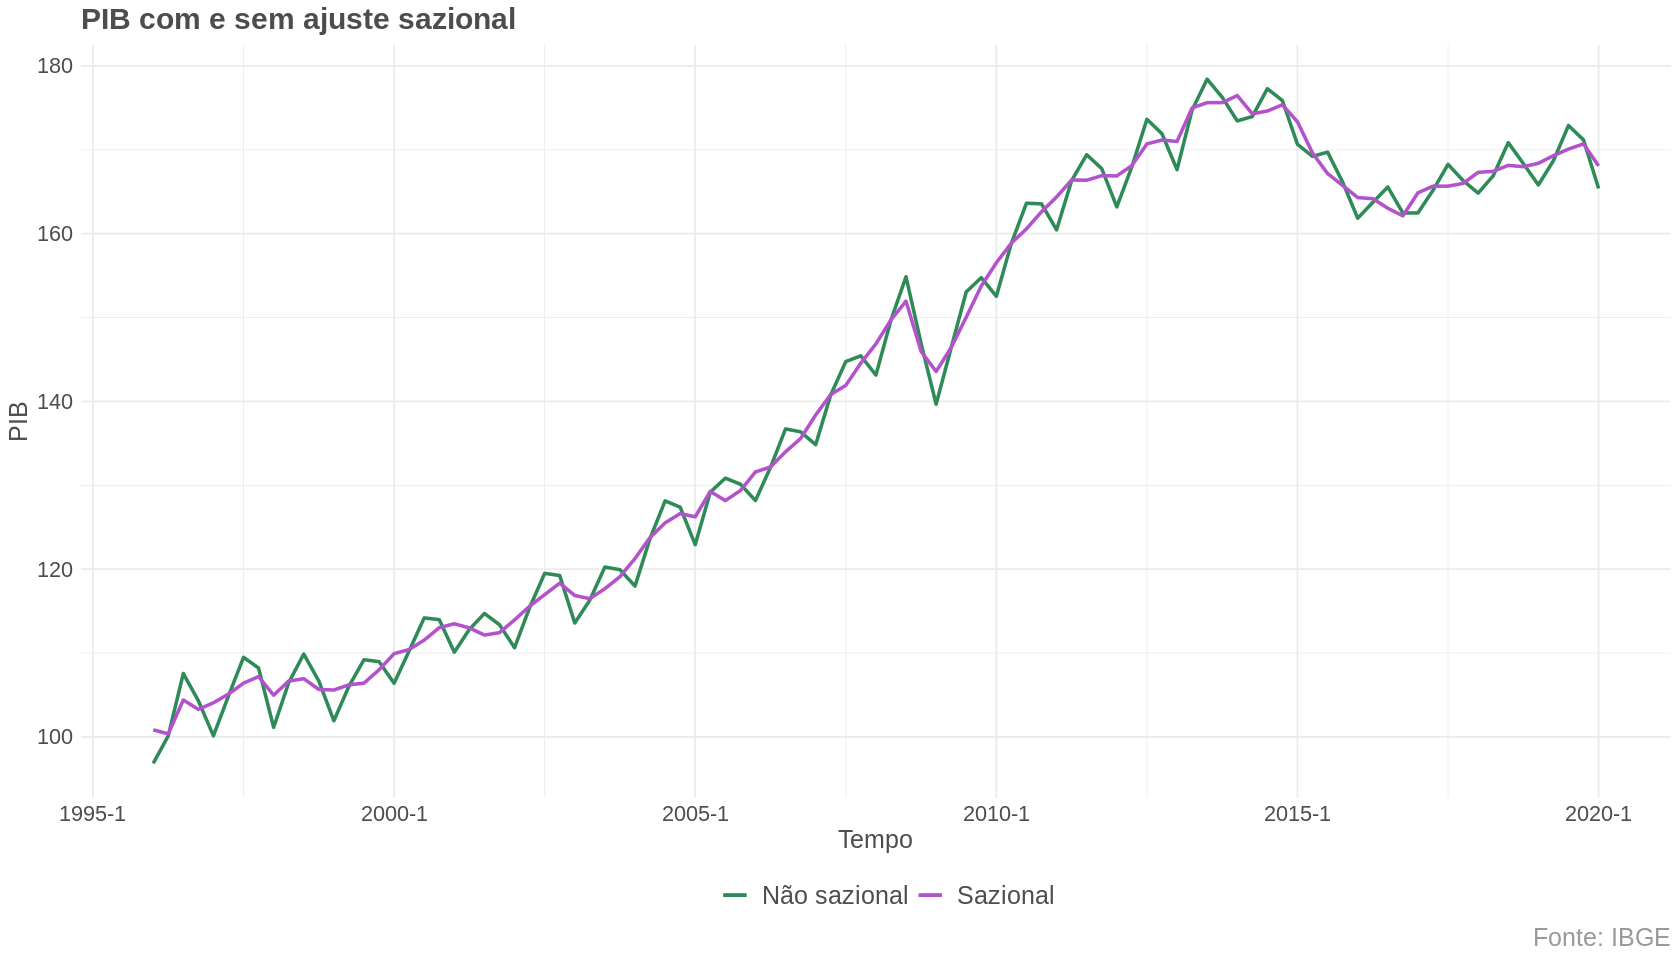

In [ ]:
# Plot da série do PIB com e sem ajuste sazonal
ggplot(tabela_pib) +
    geom_line(mapping = aes(x = date, y = pib, color = "seagreen4"), size=1) +
    geom_line(mapping = aes(x = tabela_pib_sa$date, y = tabela_pib_sa$pib_sa, color = "mediumorchid3"), size=1) +
    labs(title = 'PIB com e sem ajuste sazonal',
         x = 'Tempo', 
         y = 'PIB', 
         caption = 'Fonte: IBGE') +
    scale_color_identity(
            name = " ",
            breaks = c("seagreen4", "mediumorchid3"),
            labels = c("Não sazonal", "Sazonal"),
            guide = "legend"
          ) +
    theme + theme(legend.position="bottom")

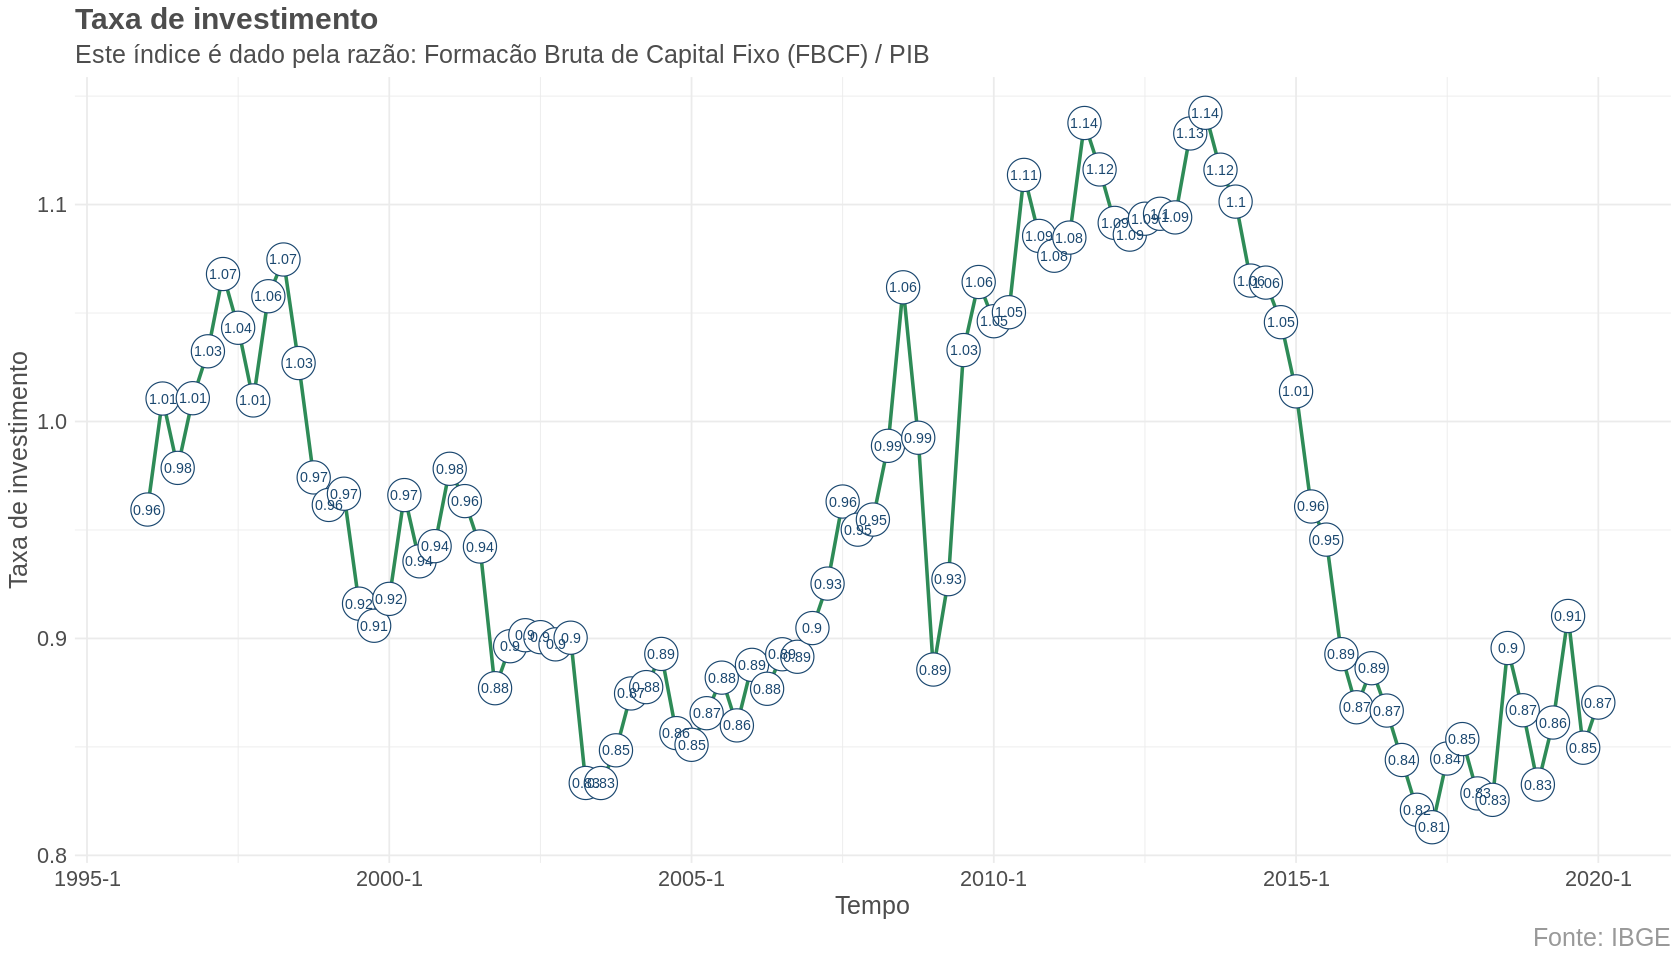

In [ ]:
# Plot da taxa de investimento
ggplot(tabela_pib, aes(x = date, y = fbcf/pib)) +
    geom_line(color = "seagreen4", size=1) + 
    geom_point(size = 9, shape=21, colour="#1a476f", fill="white")+
    geom_text(aes(label = round(fbcf/pib, 2)), size = 3, hjust=0.5, vjust=0.5, shape=21, colour="#1a476f")+
    labs(title = 'Taxa de investimento',
         subtitle = 'Este índice é dado pela razão: Formacão Bruta de Capital Fixo (FBCF) / PIB',
         x = 'Tempo', 
         y = 'Taxa de investimento' , 
         caption = 'Fonte: IBGE'         
         ) +
    theme 

Seguro Desemprego
===

In [32]:
#fornecemos o endereço dos dados
url = 'https://github.com/galvaowesley/DataScience_Learning/blob/master/minicurso_dataScience/Semana_9/3-%20S%C3%A9rie%20Hist%C3%B3rica%20do%20Seguro-Desemprego%20-%202000%20a%202020%20-%20mensal.xlsx?raw=true'
path = '/content/seguro.xlsx'
#fazemos o download

download.file(url, path, mode='wb')

#importamos usando read_excel

seg_desemprego = read_excel(path, sheet="Tabela 1", skip=5) %>% drop_na()

New names:
* `` -> ...1



...1,2000/01,2000/02,2000/03,2000/04,2000/05,2000/06,2000/07,2000/08,2000/09,⋯,2019/08,2019/09,2019/10,2019/11,2019/12,2020/01,2020/02,2020/03,2020/04,2020/05
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRASIL,343398,375906,394778,347326,386524,354720,352319,376694,320982,⋯,567069,521572,553609,511025,434285,568609,483145,536844,748540,960258
ACRE,542,410,540,424,498,412,446,402,372,⋯,1162,1174,1239,1466,1160,1247,1287,1146,1293,1372
ALAGOAS,2219,2350,2584,2765,4479,2743,2807,2653,2104,⋯,5075,4430,4252,3913,3461,4318,4043,4673,5687,8247
AMAPA,522,567,533,456,521,565,567,544,425,⋯,1410,1164,1222,1090,878,1185,1103,998,918,1321
AMAZONAS,2945,3150,3085,2745,3281,2781,2978,3389,2518,⋯,5884,5535,5908,5905,4196,6680,5713,6232,6537,10111
BAHIA,13675,16660,16515,15802,17877,15466,15097,16525,13667,⋯,27464,23992,26031,24369,20971,26236,21902,19768,34866,48076
CEARA,8680,10414,10219,9624,11344,10088,9011,9934,8726,⋯,17811,16357,16504,14457,11669,14424,13937,15150,26204,32934
DISTRITO FEDERAL,5474,6443,7098,5772,6464,6527,5988,6742,6150,⋯,10744,9779,8875,9543,8619,12438,9280,9510,14522,19520
ESPIRITO SANTO,6881,7527,8622,7415,7628,7645,7381,7832,6873,⋯,11611,9966,10586,9645,9058,11388,10451,11480,13295,18160
